In [23]:
# Standard library
import os
import sys
import re
import json
import pickle
import glob
import ast
import warnings
from pathlib import Path
import importlib

# Add custom path
sys.path.append('/root/capsule/code/beh_ephys_analysis')

# Scientific libraries
import numpy as np
import pandas as pd
import xarray as xr
import scipy.signal as signal
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# SpikeInterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw

# Progress bar
from tqdm import tqdm
import seaborn as sns
from trimesh import load_mesh

# IPython display
from IPython.display import clear_output

# Open Ephys
from open_ephys.analysis import Session

# AIND analysis and utils
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from aind_ephys_utils import align, sort

# Local utilities
import utils.analysis_funcs as af
import utils.plotting_funcs as pf
from utils.beh_functions import session_dirs
from utils.combine_tools import apply_qc
from utils.ccf_utils import pir_to_lps, project_to_plane
from utils.plot_utils import combine_pdf_big

import k3d
from scipy.stats import pearsonr

# Matplotlib inline for Jupyter
%matplotlib inline


# Pack data

In [24]:
criteria_name = 'basic_ephys'

In [25]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
    
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
    
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
target_folder = '/root/capsule/scratch/manuscript/F_antidromic/'
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

Applying bounds for isi_violations: [0.0, 0.2]
 - isi_violations: 18300 -> 9671 units passed
Applying items for qc_pass: [True]
 - qc_pass: 9671 -> 6954 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 6954 -> 6923 units passed
Applying conditional bounds for y_loc
 - y_loc: 6923 -> 5220 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto rows after filtering: 504
Number of non-opto rows after filtering: 5220


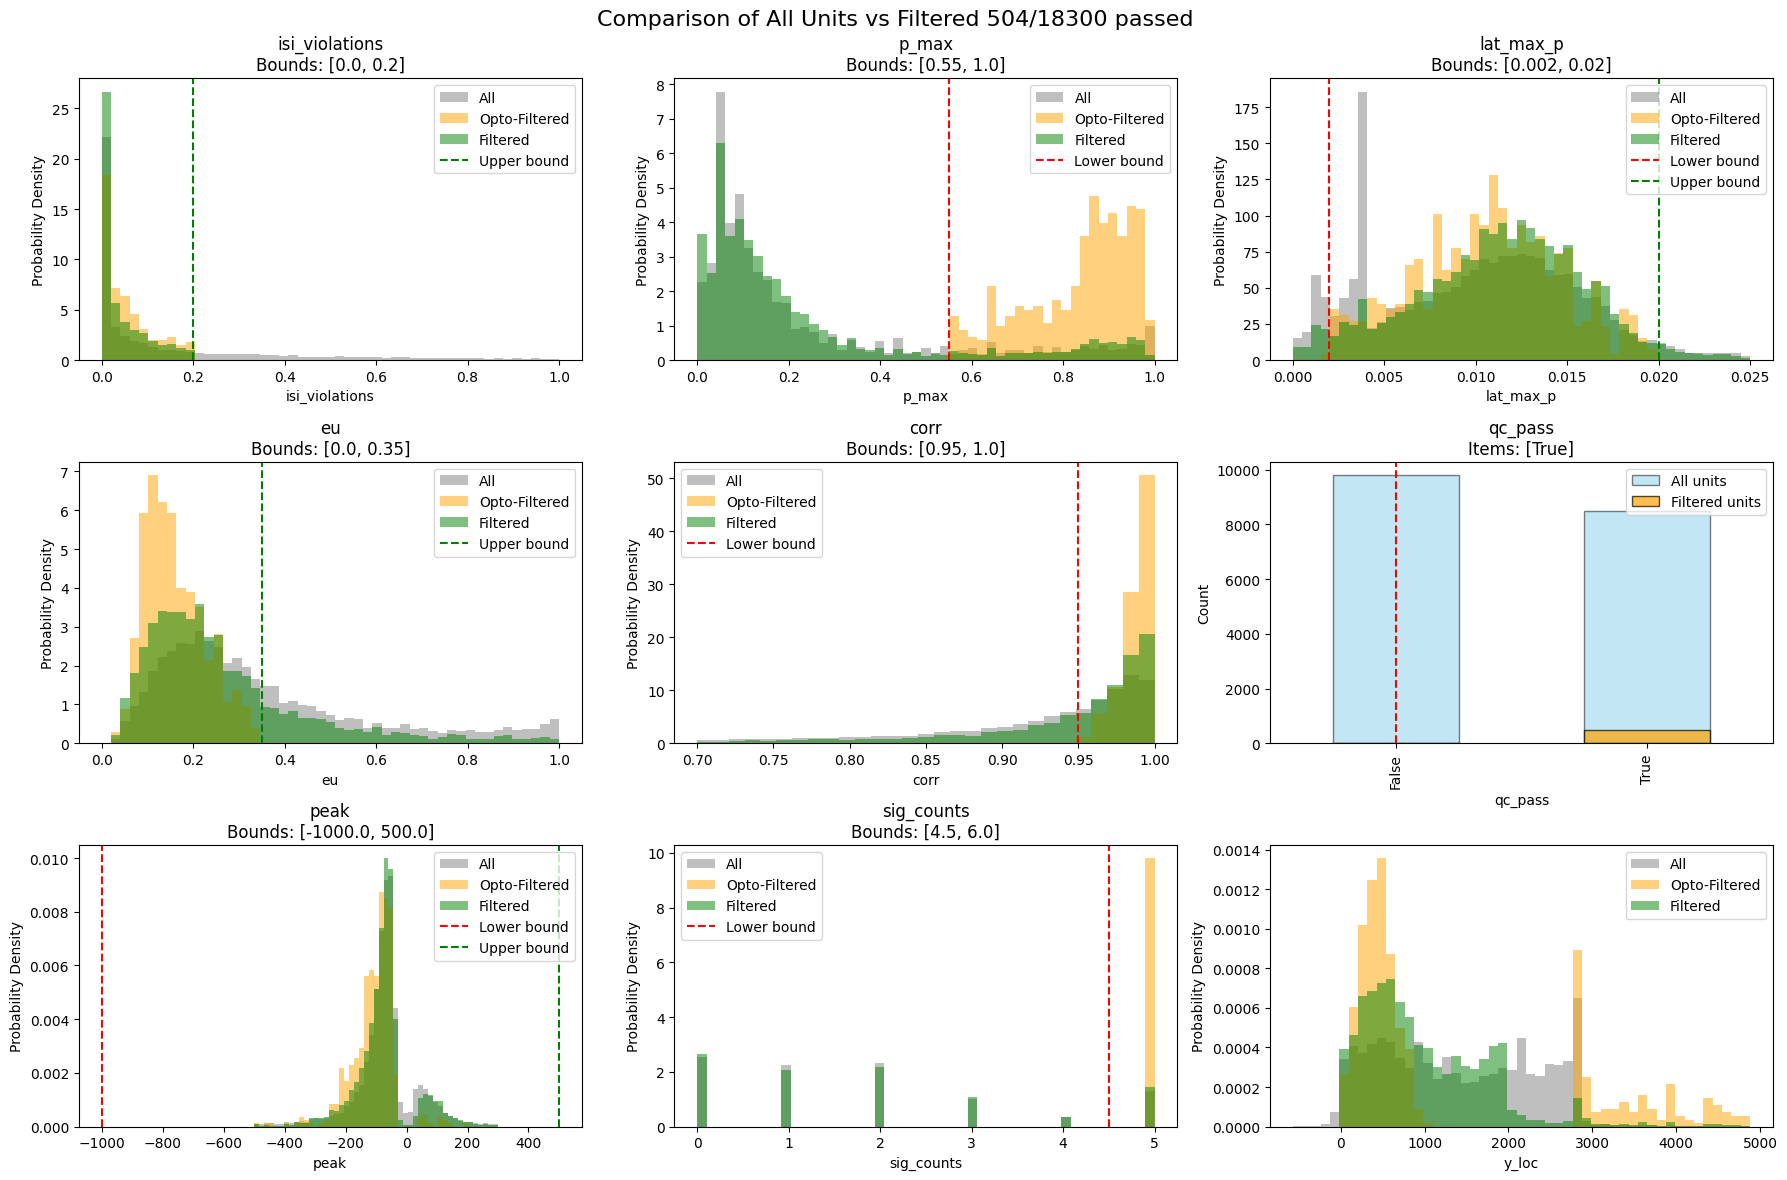

In [26]:
combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)
fig.savefig(os.path.join(target_folder, 'units_quality_metrics_summary.pdf'))

# Load antidromic units

In [27]:
session_list = combined_tagged_units_filtered[combined_tagged_units_filtered['probe']=='2']['session'].unique().tolist()
file = os.path.join(beh_folder, 'combined_antidromic_results.pkl')
re_compute = False
if os.path.exists(file):
    print(f'Loading antidromic results from {file}')
    with open(file, 'rb') as f:
        concatenate_antidromic_results = pickle.load(f)
else:
    print('Collecting antidromic analysis for sessions:')
    re_compute = True

Loading antidromic results from /root/capsule/scratch/combined/beh_plots/basic_ephys/combined_antidromic_results.pkl


In [28]:
if re_compute:
    concatenate_antidromic_results_all = []
    for session in session_list:
        session_dir = session_dirs(session)
        save_dir = os.path.join(session_dir['opto_dir_curated'], f'{session}_antidromic_results.pkl')
        if os.path.exists(save_dir):
            with open(save_dir, 'rb') as f:
                merged_df = pickle.load(f)
            merged_df['session'] = session
            concatenate_antidromic_results_all.append(merged_df)
    concatenate_antidromic_results = pd.concat(concatenate_antidromic_results_all, ignore_index=True)
    concatenate_antidromic_results.rename(columns={'unit_id': 'unit'}, inplace=True)
    file = os.path.join(beh_folder, 'combined_antidromic_results.pkl')
    with open(file, 'wb') as f:
        pickle.dump(concatenate_antidromic_results, f)

# Process target region

In [29]:
thresholds = {'t_antidromic': 0,
              't_collision': -3.5,
              'p_antidromic': 0.005,
                'p_collision': 0.005,
                'jitter': 0.02}

In [30]:
focuses = ['PrL', 'S1']
focus_save_dir = os.path.join(beh_folder, '_'.join(focuses))
os.makedirs(focus_save_dir, exist_ok=True)

all_focus_dfs = []

# --- Process each focus separately ---
for focus in focuses:
    cols_to_keep = [
        col for col in concatenate_antidromic_results.columns
        if col[1] in (f'surface_{focus}', '')  # keep both surface_PrL and no-site columns
    ]
    df_focus = concatenate_antidromic_results.loc[:, cols_to_keep]

    # Flatten MultiIndex if needed
    if isinstance(df_focus.columns, pd.MultiIndex):
        df_focus.columns = df_focus.columns.get_level_values(0)

    combined_df = df_focus.copy()
    combined_df['focus'] = focus

    # --- Derived metrics ---
    # combined_df['t_collision'] = combined_df['t_collision']
    combined_df['p_auto_inhi_log'] = np.log10(combined_df['p_auto_inhi'] + 1e-10)
    combined_df['p_collision_log'] = np.log10(combined_df['p_collision'] + 1e-10)
    combined_df['p_antidromic_log'] = np.log10(combined_df['p_antidromic'] + 1e-10)
    combined_df['t_collision_log'] = np.log10(np.abs(combined_df['t_collision']) + 1e-10) * np.sign(combined_df['t_collision'])
    combined_df['t_antidromic_log'] = np.log10(np.abs(combined_df['t_antidromic']) + 1e-10) * np.sign(combined_df['t_antidromic'])

    # --- Tier logic ---
    combined_df['tier_1'] = (
        (combined_df['jitter'] < thresholds['jitter'])
        & (combined_df['p_antidromic'] < thresholds['p_antidromic'])
        & (combined_df['t_antidromic'] > thresholds['t_antidromic'])
        & (combined_df['p_collision'] < thresholds['p_collision'])
        & (combined_df['t_collision'] < thresholds['t_collision'])
    ).astype(float)

    combined_df['tier_2'] = (
        (combined_df['jitter'] < 0.01)
        & (combined_df['p_antidromic'] < 0.005)
        & (combined_df['t_antidromic'] > 0)
    ).astype(float)

    combined_df['tier_1_long'] = (
        (combined_df['p_antidromic'] < 0.005)
        & (combined_df['t_antidromic'] > 0)
        & (combined_df['p_collision'] < 0.005)
        & (combined_df['t_collision'] < 0)
    ).astype(float)

    combined_df['tier_2_long'] = (
        (combined_df['p_antidromic'] < 0.005)
        & (combined_df['t_antidromic'] > 0)
    ).astype(float)

    combined_df['short'] = (
        (combined_df['jitter'] < 0.01)
        & (combined_df['antidromic_latency'] >= 0.025)
    ).astype(float)

    all_focus_dfs.append(combined_df)

# --- Combine all focuses ---
combined_all_focus_df = pd.concat(all_focus_dfs, ignore_index=True)


In [31]:

# --- Clean up tier columns ---
tier_cols = ['tier_1', 'tier_2', 'tier_1_long', 'tier_2_long', 'short']
# for c in tier_cols:
#     if c in combined_all_focus_df.columns:
#         combined_all_focus_df[c] = combined_all_focus_df[c].fillna(0).astype(float)

# --- Find the best (highest t_collision) per session/unit ---
combined_all_focus_df['_tcol'] = combined_all_focus_df['t_collision'].fillna(np.inf)
idx_best = combined_all_focus_df.groupby(['session', 'unit'])['_tcol'].idxmin()
best_rows = combined_all_focus_df.loc[idx_best].drop(columns=['_tcol']).copy()

# --- Compute OR (max) of tiers across focuses ---
tier_max = (
    combined_all_focus_df.groupby(['session', 'unit'])[tier_cols]
    .max()
    .reset_index()
)

In [32]:
# --- Record which focuses passed each tier ---
focus_pass_cols = {}
for tier in tier_cols:
    if tier in combined_all_focus_df.columns:
        focus_pass = (
            combined_all_focus_df[combined_all_focus_df[tier] > 0]
            .groupby(['session', 'unit'])['focus']
            .apply(lambda x: ','.join(sorted(set(x))))
            .reset_index(name=f'{tier}_focus')
        )
        focus_pass_cols[tier] = focus_pass


In [33]:
# Merge all focus-passing columns into a single dataframe
tier_focus_df = tier_max.copy()
for tier, focus_df in focus_pass_cols.items():
    tier_focus_df = tier_focus_df.merge(focus_df, on=['session', 'unit'], how='left')


In [34]:
# --- Merge with best row (highest t_collision) ---
final_combined_df = (
    best_rows.drop(columns=tier_cols, errors='ignore')
    .merge(tier_focus_df, on=['session', 'unit'], how='left')
)

# --- Save result ---
combined_df = combined_tagged_units_filtered.merge(final_combined_df, on=['session', 'unit'], how='inner')
output_pkl = os.path.join(focus_save_dir, 'combined_antidromic_results.pkl')
final_combined_df.to_pickle(output_pkl)
print(f"Saved combined dataframe (one row per session+unit): {output_pkl}")
output_pkl_full = os.path.join(target_folder, 'combined_antidromic_results.pkl')
combined_df.to_pickle(output_pkl_full)
print(f"Saved combined dataframe (one row per session+unit): {output_pkl_full}")


Saved combined dataframe (one row per session+unit): /root/capsule/scratch/combined/beh_plots/basic_ephys/PrL_S1/combined_antidromic_results.pkl
Saved combined dataframe (one row per session+unit): /root/capsule/scratch/manuscript/F_antidromic/combined_antidromic_results.pkl


In [35]:
combined_df.groupby('tier_1').count()

,session,unit,qc_pass,opto_tagged,in_df,trial_count,p_max,p_mean,sig_counts,lat_max_p,...,t_antidromic_log,tier_2,tier_1_long,tier_2_long,short,tier_1_focus,tier_2_focus,tier_1_long_focus,tier_2_long_focus,short_focus
tier_1,,,,,,,,,,,,,,,,,,,,,
0.0,221,221,221,221,221,221,221,221,221,221,...,196,221,221,221,221,0,24,14,146,30
1.0,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,13,14,14,13


In [36]:
combined_df[combined_df['tier_1'] == 1][['session', 'unit', 'jitter', 't_collision', 'isi_violations']]

,session,unit,jitter,t_collision,isi_violations
31,ecephys_713854_2024-03-08_15-43-01,3,0.0015,-4.723883,0.000000
58,behavior_751769_2025-01-17_11-37-39,288,0.0015,-28.435699,0.050636
62,behavior_751769_2025-01-18_10-15-25,29,0.0015,-5.418562,0.015074
102,behavior_751181_2025-02-26_11-51-19,39,0.0035,-4.119516,0.197619
107,behavior_751181_2025-02-26_11-51-19,273,0.0015,-15.491526,0.018729
112,behavior_751181_2025-02-27_11-24-47,46,0.0015,-4.605701,0.000000
115,behavior_751181_2025-02-27_11-24-47,244,0.0010,-11.777355,0.144242
126,behavior_754897_2025-03-13_11-20-42,49,0.0015,-32.697928,0.047414
154,behavior_752014_2025-03-26_11-18-57,46,0.0010,-20.783697,0.056336
156,behavior_752014_2025-03-28_11-04-59,27,0.0010,-26.541710,0.030950


# Plots

## Correlation between metrics

In [37]:
col_to_plot = [
    'p_auto_inhi_log', 'p_collision_log', 'p_antidromic_log', 'jitter',
    't_auto_inhi', 't_collision', 't_antidromic',
    'antidromic_latency', 'p_max', 'isi_violations', 'snr', 'amp',
    'tier_1', 'tier_2', 'tier_1_long'
]

col_to_plot = [
    'p_auto_inhi_log', 'p_collision', 'p_antidromic', 'jitter',
    't_auto_inhi', 't_collision', 't_antidromic',
    'antidromic_latency',
    'tier_1', 't_collision_log', 't_antidromic_log'
]

col_to_plot = ['jitter', 't_antidromic_log', 't_collision_log', 'antidromic_latency', 'tier_1']


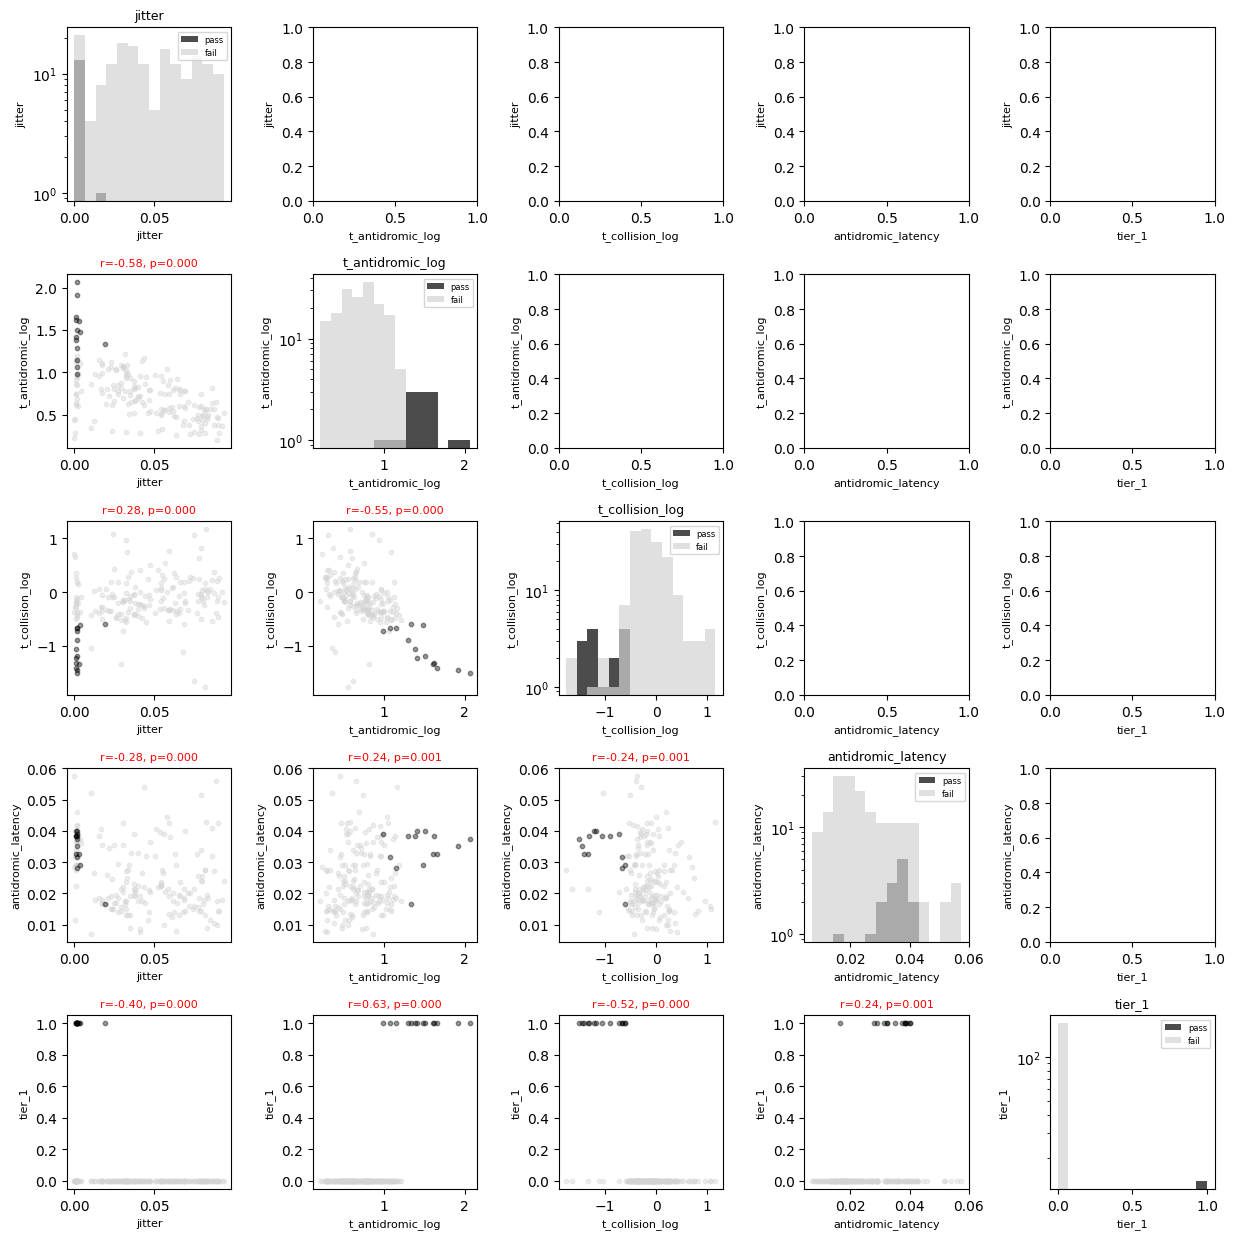

In [38]:

# Drop rows with any NaNs in the selected columns
data = combined_df[col_to_plot].dropna()
color_code = (data['jitter']<0.010) & (data['antidromic_latency']>0.02)
color_code = data['tier_1'].values > 0

n = len(col_to_plot)
fig, axes = plt.subplots(n, n, figsize=(2.5 * n, 2.5 * n))

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        x = data[col_to_plot[j]].values
        y = data[col_to_plot[i]].values
        
        if i == j:
            # diagonal: histogram
            bins = np.linspace(np.min(x), np.max(x), 15)
            ax.hist(x[color_code], bins=bins, color='k', alpha=0.7, label='pass', density=False)
            ax.hist(x[~color_code], bins=bins, color='lightgray', alpha=0.7, label='fail', density=False)
            # change y to log scale
            ax.set_yscale('log')
            ax.set_title(col_to_plot[i], fontsize=9)
            ax.legend(fontsize=6)
        elif i > j:
            # scatter plot
            
            ax.scatter(x[~color_code], y[~color_code], color='lightgray', alpha=0.4, s=10)
            ax.scatter(x[color_code], y[color_code], color='k', alpha=0.4, s=10)
            
            
            # compute Pearson correlation and p-value
            if np.isfinite(x).all() and np.isfinite(y).all() and len(x) > 1:
                r, p = pearsonr(x, y)
                color = 'red' if p < 0.05 else 'black'
                ax.set_title(f"r={r:.2f}, p={p:.3f}", color=color, fontsize=8)
            else:
                ax.set_title("r=NaN", color='black', fontsize=8)
        
        # Add x and y axis labels for every subplot
        ax.set_xlabel(col_to_plot[j], fontsize=8)
        ax.set_ylabel(col_to_plot[i], fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'antidromic_quality_metrics_matrix.pdf'), dpi=300)
plt.savefig(os.path.join(target_folder, 'antidromic_quality_metrics_matrix.svg'), dpi=300)
# plt.show()


In [39]:
from matplotlib.colors import Normalize
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

norm = Normalize(vmin=0, vmax=1)
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
mesh_vertices_mm[:, ml] = np.abs(mesh_vertices_mm[:, ml])
blue_white_red = LinearSegmentedColormap.from_list(
    'blue_white_red',
    [(0, 'red'), (0.5, 'white'), (1.0, 'blue')]
)

In [40]:
# plt.scatter(np.log(combined_df['collision_pvalue'] + 1e-20), np.log(combined_df['p_collision'] + 1e-20), c = combined_df['t_auto_inhi'], alpha=0.4)
# plt.plot([np.min(np.log(combined_df['collision_pvalue'] + 1e-20)), np.max(np.log(combined_df['collision_pvalue'] + 1e-20))],
#             [np.min(np.log(combined_df['collision_pvalue'] + 1e-20)), np.max(np.log(combined_df['collision_pvalue'] + 1e-20))], color='red')
# plt.colorbar(label='t_antidromic')
# plt.xlabel('test_log(collision_pvalue)')
# plt.ylabel('regression_log(p_collision)')

## Plot in 2D space

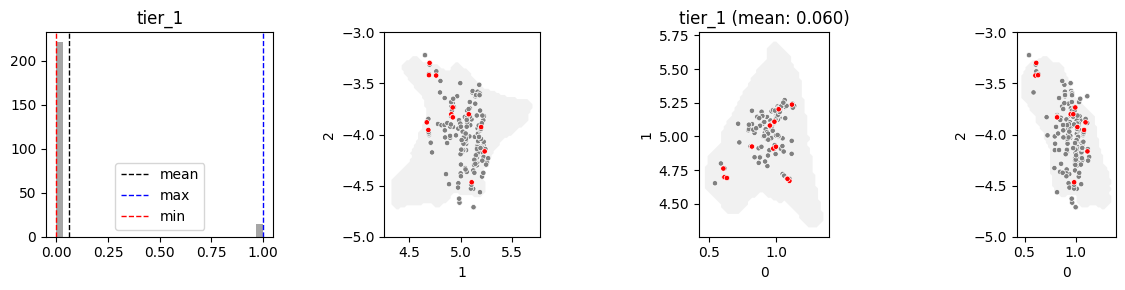

In [41]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage import binary_dilation
from skimage.measure import find_contours

features_to_plot = ['t_antidromic', 't_collision', 'jitter', 't_auto_inhi', 'short', 'tier_1', 'tier_2', 'tier_1_long', 'tier_2_long', 'p_collision']
features_to_plot = ['tier_1']

fig, axes = plt.subplots(len(features_to_plot), 4, figsize=(12, 3 * len(features_to_plot)))
axes = np.atleast_2d(axes)

# --- 3D anatomical points ---
ccfs = combined_df[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}

for ind, feature in enumerate(features_to_plot):
    color = combined_df[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize colors to 0–1 ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        center_line = 0
        upper_limit = amp_cut
        lower_limit = -amp_cut
        # === Colormap ===
        custom_cmap = LinearSegmentedColormap.from_list(
            'blue_white_red', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.nanmin(color_reg))/(amp_cut - np.nanmin(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        center_line = np.nanmean(color)
        lower_limit = np.nanmin(np.abs(color)) * np.sign(center_line)
        upper_limit = amp_cut * np.sign(center_line)
        # === Colormap ===
        custom_cmap = LinearSegmentedColormap.from_list('gray_red', [(0.0, 'gray'), (1.0, 'red')])

    color_reg[np.isnan(color_reg)] = 0.5

    # === Histogram of feature values ===
    ax_hist = axes[ind, 0]
    ax_hist.hist(combined_df[feature].values, bins=30, color='gray', alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color='k', linestyle='--', linewidth=1, label='mean')
    ax_hist.axvline(upper_limit, color='blue', linestyle='--', linewidth=1, label = 'max')
    ax_hist.axvline(lower_limit, color='red', linestyle='--', linewidth=1, label = 'min')
    ax_hist.legend()

    # # === Compute alpha scaling from rho ===
    # alpha_scale = combined_df['rho'].values[mask]
    # alpha_scale = np.sqrt(alpha_scale)               # soften scaling
    # alpha_scale = np.clip(alpha_scale, 0.2, 0.8)     # prevent extremes

    # === Sort and filter ===
    sort_ind = np.argsort(color_reg)
    ccfs_plot = ccfs[sort_ind]
    color_reg_plot = color_reg[sort_ind]
    # alpha_scale_plot = alpha_scale[sort_ind]

    # # === Precompute RGBA facecolors ===
    rgba_colors = custom_cmap(color_reg_plot)
    # rgba_colors[:, -1] = alpha_scale_plot  # inject alpha per point

    # === 2D plane projections ===
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # background mesh outline
        # ax.scatter(
        #     mesh_vertices_mm[:, planes[plane][0]],
        #     mesh_vertices_mm[:, planes[plane][1]],
        #     color='k', alpha=0.4, s=0.05, edgecolors='none'
        # )
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # scatter the points (alpha-scaled)
        sc = ax.scatter(
            ccfs_plot[:, planes[plane][0]],
            ccfs_plot[:, planes[plane][1]],
            facecolors=rgba_colors,
            edgecolors=[1, 1, 1],
            linewidths=0.5,
            alpha = 1,
            s=15
        )

        if plane == 'hor':
            value_mean = np.nanmean(combined_df[feature].values)
            ax.set_title(f'{feature} (mean: {value_mean:.3f})')
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

        if planes[plane][1] == dv:
            ax.set_ylim([-5, -3])

plt.tight_layout()
for ext in ['pdf', 'png', 'svg']:
    plt.savefig(os.path.join(target_folder, f'antidromic_spatial_{criteria_name}.{ext}'),
                bbox_inches='tight', dpi=300)

# plt.close()


## Collect figures from individual neurons

In [42]:
# grab all figures and save 
import shutil
curr_target_folder = os.path.join(target_folder, 'antidromic_figures')
# remove before copying
shutil.rmtree(curr_target_folder, ignore_errors=True)
os.makedirs(curr_target_folder, exist_ok=True)
tiers = ['tier_1', 'tier_2']
sub_classes = ['long', 'short']
for tier in tiers:
    for sub_class in sub_classes:
        shutil.rmtree(path=os.path.join(curr_target_folder, tier, sub_class), ignore_errors=True)
        os.makedirs(os.path.join(curr_target_folder, tier, sub_class), exist_ok=True)

null_folder = os.path.join(curr_target_folder, 'null_figures')
os.makedirs(null_folder, exist_ok=True)

target_folder_t1 = os.path.join(curr_target_folder, 'tier_1', 'short')
target_folder_t2 = os.path.join(curr_target_folder, 'tier_2', 'short')
target_folder_t1_long = os.path.join(curr_target_folder, 'tier_1', 'long')
target_folder_t2_long = os.path.join(curr_target_folder, 'tier_2', 'long')

for row_ind, row in combined_df.iterrows():
    session = row['session']
    unit = row['unit']
    tier_1 = row['tier_1']
    tier_2 = row['tier_2']
    tier_1_long = row['tier_1_long']
    tier_2_long = row['tier_2_long']

    # find corresponding row in combined_tagged_units_filtered to get isi_violations
    combined_tagged_units_row = combined_tagged_units_filtered[
        (combined_tagged_units_filtered['session'] == session) &
        (combined_tagged_units_filtered['unit'] == unit)
    ]
    if combined_tagged_units_row.empty:
        print(f'No matching row found in combined_tagged_units_filtered for {session} unit {unit}. Skipping.')
        isi_v = 'NaN'
    else:
        isi_v = combined_tagged_units_row.iloc[0]['isi_violations']
    
    source_folder = os.path.join(session_dirs(session)['opto_dir_curated'], 'figures', 'antidromic')
    figure_name = f'{session}_unit{unit}_opto_responses.pdf'
    source_path =  os.path.join(source_folder, figure_name)
    if not os.path.exists(source_folder):
        figure_name = f'{session}_unit{unit}.0_opto_responses.pdf'
        source_path =  os.path.join(source_folder, figure_name)
    
    if os.path.exists(source_path):
        print(f'Found figure for {session} unit {unit}.')
        if tier_1_long:
            if tier_1:
                curr_target_folder = target_folder_t1
                print(f'Copying {figure_name} to tier_1 folder...')
            else:
                curr_target_folder = target_folder_t1_long
                print(f'Copying {figure_name} to tier_1_long folder...')
        elif tier_2_long:
            if tier_2:
                curr_target_folder = target_folder_t2
                print(f'Copying {figure_name} to tier_2 folder...')
            else:
                curr_target_folder = target_folder_t2_long
                print(f'Copying {figure_name} to tier_2_long folder...')
        else:
            curr_target_folder = null_folder
            print(f'Copying {figure_name} to null folder...')
        if not np.isnan(row["jitter"]):
            jitter = int(round(1000*row["jitter"]))
        else:
            jitter = 'NA'
        
        if not np.isnan(row["antidromic_latency"]):
            antidromic_latency = int(round(1000*row["antidromic_latency"]))
        else:
            antidromic_latency = 'NA'
        shutil.copy(source_path, os.path.join(curr_target_folder, f'{session}_unit_{unit}_col_{row["t_collision"]:.1f}_anti_{row["t_antidromic"]:.1f}_lat_{antidromic_latency}_jitter_{jitter}_isi_{isi_v:.2f}.pdf'
))
    else:
        print(f'Figure not found for {session} unit {unit}.')

Found figure for ecephys_713854_2024-03-05_12-01-40 unit 64.
Copying ecephys_713854_2024-03-05_12-01-40_unit64_opto_responses.pdf to null folder...
Found figure for ecephys_713854_2024-03-05_13-01-09 unit 0.
Copying ecephys_713854_2024-03-05_13-01-09_unit0_opto_responses.pdf to null folder...
Found figure for ecephys_713854_2024-03-05_13-01-09 unit 3.
Copying ecephys_713854_2024-03-05_13-01-09_unit3_opto_responses.pdf to null folder...
Found figure for ecephys_713854_2024-03-05_13-01-09 unit 11.
Copying ecephys_713854_2024-03-05_13-01-09_unit11_opto_responses.pdf to null folder...
Found figure for ecephys_713854_2024-03-05_13-01-09 unit 15.
Copying ecephys_713854_2024-03-05_13-01-09_unit15_opto_responses.pdf to null folder...
Found figure for ecephys_713854_2024-03-05_13-01-09 unit 27.
Copying ecephys_713854_2024-03-05_13-01-09_unit27_opto_responses.pdf to null folder...
Found figure for ecephys_713854_2024-03-05_13-01-09 unit 141.
Copying ecephys_713854_2024-03-05_13-01-09_unit141_opt

In [43]:
# combine pdfs
curr_target_folder = os.path.join(target_folder, 'antidromic_figures')
for tier in tiers:
    for sub_class in sub_classes:
        input_folder = os.path.join(curr_target_folder, tier, sub_class)
        output_pdf = os.path.join(curr_target_folder, f'antidromic_{focus}_{tier}_{sub_class}.pdf')
        combine_pdf_big(input_folder, output_pdf)
        print(f'Combined PDF saved to {output_pdf}')

Processing 15 files in /root/capsule/scratch/manuscript/F_antidromic/antidromic_figures/tier_1/long
Combined PDF saved as: /root/capsule/scratch/manuscript/F_antidromic/antidromic_figures/antidromic_S1_tier_1_long.pdf
Combined PDF saved to /root/capsule/scratch/manuscript/F_antidromic/antidromic_figures/antidromic_S1_tier_1_long.pdf
Processing 15 files in /root/capsule/scratch/manuscript/F_antidromic/antidromic_figures/tier_1/short
Combined PDF saved as: /root/capsule/scratch/manuscript/F_antidromic/antidromic_figures/antidromic_S1_tier_1_short.pdf
Combined PDF saved to /root/capsule/scratch/manuscript/F_antidromic/antidromic_figures/antidromic_S1_tier_1_short.pdf
Processing 111 files in /root/capsule/scratch/manuscript/F_antidromic/antidromic_figures/tier_2/long
Combined PDF saved as: /root/capsule/scratch/manuscript/F_antidromic/antidromic_figures/antidromic_S1_tier_2_long.pdf
Combined PDF saved to /root/capsule/scratch/manuscript/F_antidromic/antidromic_figures/antidromic_S1_tier_2_